In [1]:
import csv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import datasets

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
device = 'cuda'
model_name = '../pipeline/wikitext_randseq'
gpt2_tokenizer = True
model_precision = "float16"
max_length = 2048
input_fn = './propagation_inputs.csv'
output_fn = f'./null_hypothesis_scores.csv'

seed = 119
seq_len = 10
vocab_size = 80
n = 10000

In [3]:
if gpt2_tokenizer:
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
if model_precision == "float16":
    model = AutoModelForCausalLM.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16,
                                                 return_dict=True).to(device)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name, return_dict=True).to(device)

2023-10-25 21:51:05.281064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
np.random.seed(seed)
labels = np.random.randint(0, vocab_size, size=(seq_len,))
labels

array([66, 34, 34, 26, 54, 39, 36, 44,  6, 72])

In [6]:
our_wm = ' Watermark: ' + tokenizer.decode(labels)
our_wm

" Watermark: cCC;WHEM'i"

In [7]:
labels = np.random.randint(0, vocab_size, size=(n, seq_len))
labels

array([[72, 78, 24, ...,  2, 27, 56],
       [24, 78, 43, ..., 71, 69, 40],
       [79,  6, 16, ..., 38, 79, 59],
       ...,
       [51, 63, 74, ..., 38, 79,  1],
       [53, 64,  1, ..., 77, 55, 50],
       [ 6, 30, 54, ..., 58,  4, 21]])

In [8]:
watermarks = []
for l in labels:
    wm = ' Watermark: ' + tokenizer.decode(l)    # prepend a fixed string
    watermarks.append(wm)
watermarks

[' Watermark: io9K/;k#<Y',
 ' Watermark: 9oLM>^0hfI',
 " Watermark: p'1pA3GGp\\",
 ' Watermark: lIN,l4bc?E',
 ' Watermark: b-b9cT0B&%',
 " Watermark: :bm8fk@'IE",
 ' Watermark: d5IjkU\\iL2',
 ' Watermark: k!8`=\\U!jS',
 " Watermark: 9*JE+B>F'l",
 ' Watermark: IjfTVV#]MX',
 ' Watermark: &8NL^j&!Y7',
 ' Watermark: Opl`Of^mn=',
 ' Watermark: GKj_$P?03T',
 ' Watermark: GY8g.MN9FG',
 ' Watermark: Q*>>$0($97',
 ' Watermark: 3QP3*bYk@:',
 " Watermark: *)!?,'aL8+",
 ' Watermark: AG8?\\/B4IB',
 ' Watermark: pjT!=D%mo;',
 " Watermark: 89nP5J'FPD",
 ' Watermark: (4NbdMi*CE',
 ' Watermark: AP9j5IoZd^',
 ' Watermark: o<cf>))QL+',
 " Watermark: >i,']3_YRN",
 ' Watermark: $2G6,#3=bO',
 ' Watermark: hf@JW@(?Kp',
 ' Watermark: U31EE2;A[+',
 ' Watermark: nC];&)G^!0',
 ' Watermark: `W%Z,+c?>6',
 " Watermark: URR4)0e'Do",
 ' Watermark: 3OZ:FK[`"o',
 ' Watermark: ]N#IJPQ5\\*',
 ' Watermark: b(LOXeK>K9',
 ' Watermark: V-O*QMO07X',
 ' Watermark: V"\'5Kj]Km9',
 ' Watermark: XGnm%A(:_T',
 ' Watermark: 0?oIjV25

In [9]:
out_fh = open(output_fn, 'wt')
out = csv.writer(out_fh)

In [10]:
input_ids = tokenizer.encode(our_wm, \
                             return_tensors='pt', \
                             max_length=None, \
                             padding=False).to(device)

input_ids = input_ids[:,-max_length:]

with torch.no_grad():
    model.eval()
    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    logits = outputs.logits

print(our_wm, loss.item())
out.writerow([wm, loss.item()])

 Watermark: cCC;WHEM'i 3.294921875


36

In [11]:
for i, wm in enumerate(watermarks):
    input_ids = tokenizer.encode(wm, \
                                 return_tensors='pt', \
                                 max_length=None, \
                                 padding=False).to(device)
    
    input_ids = input_ids[:,-max_length:]
    
    with torch.no_grad():
        model.eval()
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        logits = outputs.logits

    if i % 100 == 0:
        print(wm, loss.item())

    out.writerow([wm, loss.item()])

 Watermark: io9K/;k#<Y 9.78125
 Watermark: RG4mpWFj<) 10.265625
 Watermark: '!2XmWSOg7 8.6328125
 Watermark: C)e::DjdQj 8.375
 Watermark: QHDMHAKl-` 8.671875
 Watermark: lSZliNP)!) 9.8359375
 Watermark: 5n\8E!>j%P 9.875
 Watermark: KY:"P=cOjh 8.7578125
 Watermark: ppl9:(*?HX 9.46875
 Watermark: E_M;4dL0#( 10.453125
 Watermark: &4V,CQOl95 9.015625
 Watermark: VQkeB,M;Ji 7.9921875
 Watermark: Rk?=B=-*;9 10.5
 Watermark: XK$Q9I&7m= 9.25
 Watermark: N=hX#-b58\ 10.2890625
 Watermark: !2NT_%QFi0 10.328125
 Watermark: XRfJg5;7<. 7.23046875
 Watermark: `iF?-#D=-H 10.34375
 Watermark: l:$$U2DNOa 8.3671875
 Watermark: B&mH2[7%_& 9.9921875
 Watermark: U>N\<oY2!` 9.7421875
 Watermark: (?gp&bR3.d 9.09375
 Watermark: ^"M0+NlC]6 9.8125
 Watermark: !W7)SF2MGI 9.578125
 Watermark: gK*,mfj`-2 8.703125
 Watermark: ;h^A7dFF#3 9.3984375
 Watermark: 4p^D&!:96[ 10.453125
 Watermark: )GKYB.)h_B 9.4375
 Watermark: ;DOnn:R$fk 9.0390625
 Watermark: `6:=@o<oDY 10.65625
 Watermark: :X#h<;"od> 10.5546875
 Watermark

In [12]:
out_fh.close()

In [15]:
with open(output_fn, 'rt') as fh:
    reader = csv.reader(fh)
    ppls = list(float(i[1]) for i in reader)

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'sequence perplexity')

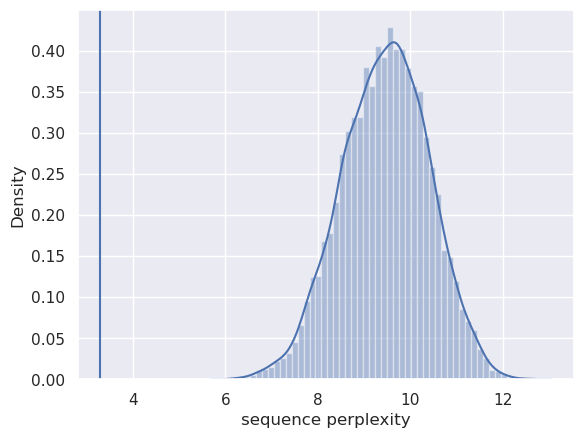

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

test_statistic = ppls[0]
sns.distplot(ppls[1:])
plt.axvline(test_statistic)
plt.xlabel('sequence perplexity')